# **Intial Setup**


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device and seeds
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Hyperparameters
BATCH_SIZE = 64
IMAGE_SIZE = 32
PATCH_SIZE = 4
LEARNING_RATE = 2e-4
DROP_RATE = 0.3
MLP_DIM = 256
EMBED_DIM = 192
NUM_HEADS = 6
EPOCHS = 30
NUM_CLASSES = 10
CHANNELS = 3
DEPTH = 4

# Dataset setup
transform_train = transforms.Compose([
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

100%|██████████| 170M/170M [00:05<00:00, 29.5MB/s]


Train samples: 50000, Test samples: 10000


# **Vision Transformer**

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (image_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

        print(f"PatchEmbedding: {num_patches}")

    def forward(self, x):
        B = x.size(0)
        # PatchEmbedding input: torch.Size([64, 3, 32, 32])

        x = self.proj(x) # (B, embed_dim, H/patch_size, W/patch_size)
        # After projection: torch.Size([64, 192, 8, 8])

        x = x.flatten(2).transpose(1, 2) # (B, num_patches, embed_dim)
        # After flatten/transpose: torch.Size([64, 64, 192])

        cls_token = self.cls_token.expand(B, -1, -1)
        # Class token expanded: torch.Size([64, 1, 192])

        x = torch.cat((cls_token, x), dim=1) # (B, 1 + num_patches, embed_dim)
        # After adding class token: torch.Size([64, 65, 192])

        x = x + self.pos_embed
        # After adding positional embeddings: torch.Size([64, 65, 192])

        return x

In [3]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        # MLP input: torch.Size([64, 65, 192])
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        # MLP output: torch.Size([64, 65, 192])
        return x

In [4]:
class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        # Encoder Layer input: torch.Size([64, 65, 192])

        # Attention with residual connection
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        # After attention: torch.Size([64, 65, 192])

        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))
        # After MLP: torch.Size([64, 65, 192])

        return x

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, in_channels, embed_dim)
        self.dropout = nn.Dropout(drop_rate)

        self.encoder = nn.Sequential(*[
            EncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        print(f"VisionTransformer: {depth} encoder layers, {embed_dim}->{num_classes} classifier")

    def forward(self, x):
        # ViT input: torch.Size([64, 3, 32, 32])

        x = self.patch_embed(x)
        # After patch embedding: torch.Size([64, 65, 192])

        x = self.dropout(x)
        # After embedding dropout: torch.Size([64, 65, 192])

        x = self.encoder(x)

        x = self.norm(x) # Apply LayerNorm before extracting class token

        cls_token = x[:, 0]  # Extract class token
        # Class token: torch.Size([64, 192])

        output = self.head(cls_token)
        # Final output: torch.Size([64, 10])
        return output

In [6]:
model = VisionTransformer(IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES, EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE).to(device)

PatchEmbedding: 64
VisionTransformer: 4 encoder layers, 192->10 classifier


# **Traning**

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [8]:
def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss, correct = 0, 0

    for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate(model, loader, loss_fn):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(dim=1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [9]:
train_accuracies, test_accuracies = [], []
train_losses, test_losses = [], []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
    test_loss, test_acc = evaluate(model, test_loader, loss_fn)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

print(f"\nFinal Results:")
print(f"Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Test Accuracy: {test_accuracies[-1]:.4f}")

  3%|▎         | 1/30 [01:41<48:58, 101.32s/it]

Epoch: 1/30, Train loss: 2.1414, Train acc: 0.1997, Test loss: 1.8802, Test acc: 0.3055


  7%|▋         | 2/30 [03:19<46:17, 99.18s/it] 

Epoch: 2/30, Train loss: 2.0199, Train acc: 0.2585, Test loss: 1.7905, Test acc: 0.3348


 10%|█         | 3/30 [04:56<44:11, 98.21s/it]

Epoch: 3/30, Train loss: 1.9311, Train acc: 0.2948, Test loss: 1.6438, Test acc: 0.4067


 13%|█▎        | 4/30 [06:32<42:15, 97.53s/it]

Epoch: 4/30, Train loss: 1.8566, Train acc: 0.3242, Test loss: 1.5714, Test acc: 0.4400


 17%|█▋        | 5/30 [08:08<40:24, 96.98s/it]

Epoch: 5/30, Train loss: 1.8048, Train acc: 0.3428, Test loss: 1.5700, Test acc: 0.4490


 20%|██        | 6/30 [09:44<38:41, 96.75s/it]

Epoch: 6/30, Train loss: 1.7646, Train acc: 0.3611, Test loss: 1.4986, Test acc: 0.4630


 23%|██▎       | 7/30 [11:21<37:05, 96.77s/it]

Epoch: 7/30, Train loss: 1.7280, Train acc: 0.3699, Test loss: 1.4632, Test acc: 0.4726


 27%|██▋       | 8/30 [12:59<35:39, 97.26s/it]

Epoch: 8/30, Train loss: 1.7076, Train acc: 0.3803, Test loss: 1.4493, Test acc: 0.4806


 30%|███       | 9/30 [14:36<33:58, 97.09s/it]

Epoch: 9/30, Train loss: 1.6822, Train acc: 0.3885, Test loss: 1.4254, Test acc: 0.4870


 33%|███▎      | 10/30 [16:12<32:12, 96.64s/it]

Epoch: 10/30, Train loss: 1.6495, Train acc: 0.4007, Test loss: 1.3659, Test acc: 0.5082


 37%|███▋      | 11/30 [17:48<30:34, 96.54s/it]

Epoch: 11/30, Train loss: 1.6383, Train acc: 0.4077, Test loss: 1.3541, Test acc: 0.5155


 40%|████      | 12/30 [19:24<28:52, 96.26s/it]

Epoch: 12/30, Train loss: 1.6152, Train acc: 0.4124, Test loss: 1.3832, Test acc: 0.5007


 43%|████▎     | 13/30 [21:00<27:14, 96.13s/it]

Epoch: 13/30, Train loss: 1.6051, Train acc: 0.4191, Test loss: 1.3134, Test acc: 0.5311


 47%|████▋     | 14/30 [22:36<25:40, 96.26s/it]

Epoch: 14/30, Train loss: 1.5842, Train acc: 0.4281, Test loss: 1.3040, Test acc: 0.5300


 50%|█████     | 15/30 [24:13<24:06, 96.44s/it]

Epoch: 15/30, Train loss: 1.5655, Train acc: 0.4339, Test loss: 1.2906, Test acc: 0.5414


 53%|█████▎    | 16/30 [25:50<22:33, 96.69s/it]

Epoch: 16/30, Train loss: 1.5494, Train acc: 0.4386, Test loss: 1.3203, Test acc: 0.5289


 57%|█████▋    | 17/30 [27:31<21:10, 97.77s/it]

Epoch: 17/30, Train loss: 1.5367, Train acc: 0.4424, Test loss: 1.2937, Test acc: 0.5422


 60%|██████    | 18/30 [29:08<19:33, 97.79s/it]

Epoch: 18/30, Train loss: 1.5179, Train acc: 0.4526, Test loss: 1.2771, Test acc: 0.5472


 63%|██████▎   | 19/30 [30:45<17:52, 97.49s/it]

Epoch: 19/30, Train loss: 1.5080, Train acc: 0.4565, Test loss: 1.2515, Test acc: 0.5550


 67%|██████▋   | 20/30 [32:21<16:11, 97.12s/it]

Epoch: 20/30, Train loss: 1.4955, Train acc: 0.4594, Test loss: 1.2374, Test acc: 0.5586


 70%|███████   | 21/30 [33:58<14:31, 96.86s/it]

Epoch: 21/30, Train loss: 1.4832, Train acc: 0.4656, Test loss: 1.2230, Test acc: 0.5697


 73%|███████▎  | 22/30 [35:34<12:53, 96.75s/it]

Epoch: 22/30, Train loss: 1.4748, Train acc: 0.4690, Test loss: 1.2248, Test acc: 0.5635


 77%|███████▋  | 23/30 [37:11<11:16, 96.66s/it]

Epoch: 23/30, Train loss: 1.4662, Train acc: 0.4710, Test loss: 1.2288, Test acc: 0.5601


 80%|████████  | 24/30 [38:51<09:45, 97.65s/it]

Epoch: 24/30, Train loss: 1.4469, Train acc: 0.4803, Test loss: 1.1955, Test acc: 0.5727


 83%|████████▎ | 25/30 [40:28<08:08, 97.60s/it]

Epoch: 25/30, Train loss: 1.4376, Train acc: 0.4816, Test loss: 1.1652, Test acc: 0.5848


 87%|████████▋ | 26/30 [42:05<06:30, 97.53s/it]

Epoch: 26/30, Train loss: 1.4297, Train acc: 0.4860, Test loss: 1.1670, Test acc: 0.5800


 90%|█████████ | 27/30 [43:43<04:52, 97.52s/it]

Epoch: 27/30, Train loss: 1.4164, Train acc: 0.4905, Test loss: 1.1817, Test acc: 0.5831


 93%|█████████▎| 28/30 [45:23<03:16, 98.43s/it]

Epoch: 28/30, Train loss: 1.4031, Train acc: 0.4944, Test loss: 1.1864, Test acc: 0.5783


 97%|█████████▋| 29/30 [47:01<01:38, 98.16s/it]

Epoch: 29/30, Train loss: 1.4005, Train acc: 0.4979, Test loss: 1.1444, Test acc: 0.5953


100%|██████████| 30/30 [48:37<00:00, 97.25s/it]

Epoch: 30/30, Train loss: 1.3911, Train acc: 0.5001, Test loss: 1.1311, Test acc: 0.5951

Final Results:
Train Accuracy: 0.5001
Test Accuracy: 0.5951


# **Plot Results**

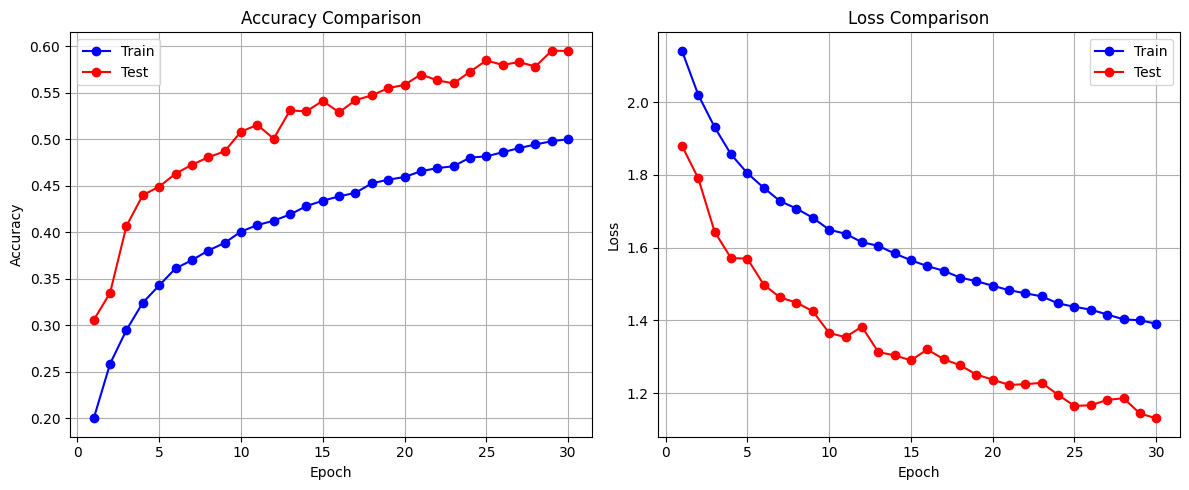

In [10]:
epochs = range(1, EPOCHS + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax1.plot(epochs, train_accuracies, 'bo-', label='Train')
ax1.plot(epochs, test_accuracies, 'ro-', label='Test')
ax1.set_title('Accuracy Comparison')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot Loss
ax2.plot(epochs, train_losses, 'bo-', label='Train')
ax2.plot(epochs, test_losses, 'ro-', label='Test')
ax2.set_title('Loss Comparison')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# **Continue Training**

In [11]:
ADDITIONAL_EPOCHS = 20

print(f"Continuing training for {ADDITIONAL_EPOCHS} more epochs...")
print(f"Starting from epoch {len(train_accuracies) + 1}")

for epoch in tqdm(range(ADDITIONAL_EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
    test_loss, test_acc = evaluate(model, test_loader, loss_fn)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    current_epoch = len(train_accuracies)
    print(f"Epoch: {current_epoch}/{len(train_accuracies) + ADDITIONAL_EPOCHS - len(train_accuracies) + current_epoch}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

print(f"\nFinal Results after {len(train_accuracies)} total epochs:")
print(f"Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Test Accuracy: {test_accuracies[-1]:.4f}")

Continuing training for 20 more epochs...
Starting from epoch 31


  5%|▌         | 1/20 [01:38<31:14, 98.64s/it]

Epoch: 31/51, Train loss: 1.3801, Train acc: 0.5035, Test loss: 1.1147, Test acc: 0.6079


 10%|█         | 2/20 [03:15<29:15, 97.55s/it]

Epoch: 32/52, Train loss: 1.3703, Train acc: 0.5059, Test loss: 1.1357, Test acc: 0.5966


 15%|█▌        | 3/20 [04:52<27:32, 97.22s/it]

Epoch: 33/53, Train loss: 1.3581, Train acc: 0.5138, Test loss: 1.1115, Test acc: 0.6050


 20%|██        | 4/20 [06:33<26:23, 98.98s/it]

Epoch: 34/54, Train loss: 1.3505, Train acc: 0.5151, Test loss: 1.1376, Test acc: 0.5989


 25%|██▌       | 5/20 [08:10<24:31, 98.11s/it]

Epoch: 35/55, Train loss: 1.3414, Train acc: 0.5218, Test loss: 1.0906, Test acc: 0.6160


 30%|███       | 6/20 [09:47<22:48, 97.73s/it]

Epoch: 36/56, Train loss: 1.3262, Train acc: 0.5253, Test loss: 1.0839, Test acc: 0.6145


 35%|███▌      | 7/20 [11:24<21:08, 97.57s/it]

Epoch: 37/57, Train loss: 1.3206, Train acc: 0.5252, Test loss: 1.0851, Test acc: 0.6120


 40%|████      | 8/20 [13:01<19:29, 97.43s/it]

Epoch: 38/58, Train loss: 1.3062, Train acc: 0.5316, Test loss: 1.1044, Test acc: 0.6182


 45%|████▌     | 9/20 [14:39<17:50, 97.34s/it]

Epoch: 39/59, Train loss: 1.2997, Train acc: 0.5365, Test loss: 1.0498, Test acc: 0.6281


 50%|█████     | 10/20 [16:16<16:13, 97.31s/it]

Epoch: 40/60, Train loss: 1.2952, Train acc: 0.5373, Test loss: 1.0871, Test acc: 0.6171


 55%|█████▌    | 11/20 [17:53<14:36, 97.37s/it]

Epoch: 41/61, Train loss: 1.2840, Train acc: 0.5432, Test loss: 1.0435, Test acc: 0.6268


 60%|██████    | 12/20 [19:30<12:57, 97.13s/it]

Epoch: 42/62, Train loss: 1.2692, Train acc: 0.5468, Test loss: 1.0186, Test acc: 0.6385


 65%|██████▌   | 13/20 [21:06<11:18, 96.92s/it]

Epoch: 43/63, Train loss: 1.2672, Train acc: 0.5489, Test loss: 1.0253, Test acc: 0.6348


 70%|███████   | 14/20 [22:42<09:40, 96.69s/it]

Epoch: 44/64, Train loss: 1.2593, Train acc: 0.5493, Test loss: 1.0240, Test acc: 0.6348


 75%|███████▌  | 15/20 [24:19<08:03, 96.69s/it]

Epoch: 45/65, Train loss: 1.2485, Train acc: 0.5551, Test loss: 1.0163, Test acc: 0.6412


 80%|████████  | 16/20 [25:55<06:25, 96.48s/it]

Epoch: 46/66, Train loss: 1.2441, Train acc: 0.5539, Test loss: 1.0289, Test acc: 0.6376


 85%|████████▌ | 17/20 [27:31<04:49, 96.35s/it]

Epoch: 47/67, Train loss: 1.2437, Train acc: 0.5570, Test loss: 0.9895, Test acc: 0.6517


 90%|█████████ | 18/20 [29:07<03:12, 96.21s/it]

Epoch: 48/68, Train loss: 1.2294, Train acc: 0.5628, Test loss: 1.0015, Test acc: 0.6493


 95%|█████████▌| 19/20 [30:43<01:36, 96.11s/it]

Epoch: 49/69, Train loss: 1.2230, Train acc: 0.5636, Test loss: 0.9882, Test acc: 0.6497


100%|██████████| 20/20 [32:19<00:00, 96.96s/it]

Epoch: 50/70, Train loss: 1.2099, Train acc: 0.5687, Test loss: 0.9861, Test acc: 0.6501

Final Results after 50 total epochs:
Train Accuracy: 0.5687
Test Accuracy: 0.6501


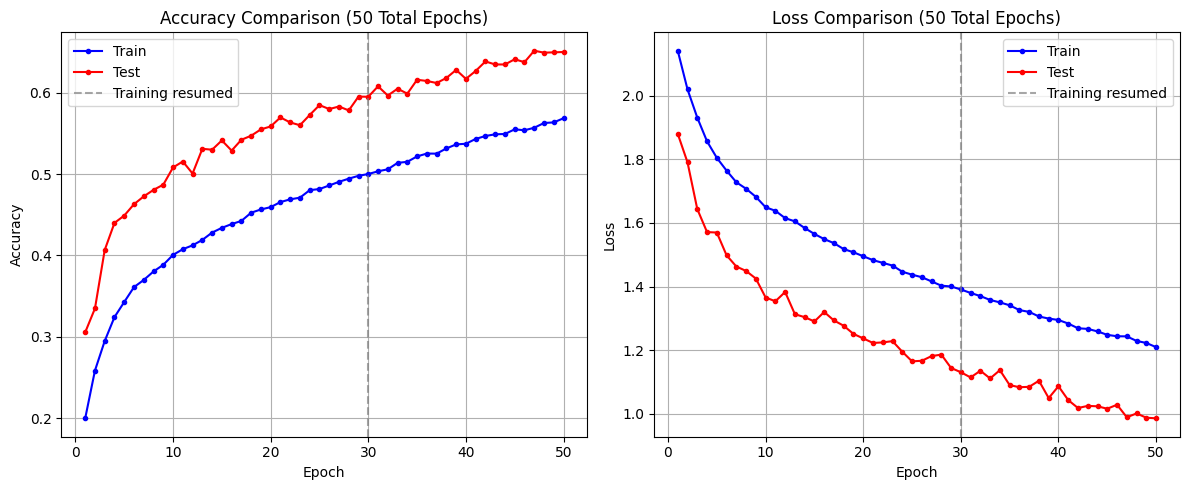

In [12]:
total_epochs = range(1, len(train_accuracies) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax1.plot(total_epochs, train_accuracies, 'bo-', label='Train', markersize=3)
ax1.plot(total_epochs, test_accuracies, 'ro-', label='Test', markersize=3)
ax1.axvline(x=30, color='gray', linestyle='--', alpha=0.7, label='Training resumed')
ax1.set_title('Accuracy Comparison (50 Total Epochs)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot Loss
ax2.plot(total_epochs, train_losses, 'bo-', label='Train', markersize=3)
ax2.plot(total_epochs, test_losses, 'ro-', label='Test', markersize=3)
ax2.axvline(x=30, color='gray', linestyle='--', alpha=0.7, label='Training resumed')
ax2.set_title('Loss Comparison (50 Total Epochs)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()